# Řešíme úlohu:
$$\begin{equation*}
    \rho (\frac{\partial \mathbf{u}}{\partial t} + (\mathbf{u} \cdot \nabla)\mathbf{u}) = -\nabla p + \mu \nabla^2 \mathbf{u} +\rho \mathbf{g}
\end{equation*}$$
na množině $\Omega = [0,\,10]\times[0,\,10] \setminus B_1(5,\,5)$

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
import numpy as np
import sys

In [3]:
# Import vlastnich modulu
sys.path.append('../')
from src.models.mlp_model import MLPModel
import src.data.cube_domain as cb
from src import train
from src import calculus as calc
import src.utils as ut

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
RHO = 1
MU = 0
P_0 = 1

def loss_interior(x: torch.Tensor, model: torch.nn.Module) -> torch.Tensor:
    x.requires_grad_(True)
    output = model(x)
    p = output[:, -1]
    u = output[:, :-1]
    rhs = RHO * calc.material_derivative(x, u, True, device)
    lhs = - calc.nabla(x, p, True)[:, :-1] + RHO * torch.tensor([0.0, -0.1], device=device)
    return torch.mean((rhs - lhs)**2)


def compute_side_loss(input: torch.Tensor, model: torch.Tensor) -> torch.Tensor:
    out = model(input)
    u = out[:, :-1]
    u_loss = torch.mean(u**2)
    return u_loss


def loss_fn(model: torch.nn.Module, domain: cb.CubeDomain):
    # loss interior
    int_in = domain.interior.requires_grad_(True)
    interior_loss = loss_interior(int_in, model)

    #zero time interior loss
    u_int_init = model(domain.sides[2][0])
    init_interior_loss = torch.mean(u_int_init**2)

    # loss right
    right_in = domain.sides[0][1].requires_grad_(True)
    p_right = model(right_in)[:, -1]
    right_loss = torch.mean(p_right**2)

    # loss top
    top_in = domain.sides[1][1].requires_grad_(True)
    top_loss = compute_side_loss(top_in, model)

    # bottom loss
    bot_in = domain.sides[1][0].requires_grad_(True)
    bot_loss = compute_side_loss(bot_in, model)

    # left loss
    left_in = domain.sides[0][0].requires_grad_(True)
    u_left = model(left_in)[:, :-1]
    inlet = torch.cat((left_in[:, 2:3], torch.zeros((left_in.shape[0], 1), device=device)), dim=1)
    inlet_loss = torch.mean((u_left - inlet)**2)
    left_loss = inlet_loss

    # print(f"interior loss: {interior_loss}")
    # print(f"init interior loss: {init_interior_loss}")
    # print(f"right loss: {right_loss}")
    # print(f"bot loss: {bot_loss}")
    # print(f"top loss: {top_loss}")
    # print(f"left loss: {left_loss}")
    # print()
    # print()

    return interior_loss + right_loss + bot_loss + top_loss + left_loss + init_interior_loss

In [6]:
dom_ctx = cb.CubeContext(
    l_bounds=[0, 0, 0],
    u_bounds=[1, 2, 3],
    dim=3,
    N_int=5_000,
    N_sides=[(100, 100), (100, 100), (100, 100)],
    device=device,
)

domain = cb.CubeDomain(dom_ctx)
model = MLPModel(3, 3, [128, 128, 128, 128], dom_ctx.u_bounds, dom_ctx.l_bounds).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
domain.generate_points()

tensor([[0.0809, 1.6145, 1.2233],
        [0.2953, 1.4327, 1.4634],
        [0.3380, 1.0398, 2.9811],
        ...,
        [0.9991, 0.7591, 2.8234],
        [0.1131, 0.4981, 2.9811],
        [0.0921, 1.8565, 0.2664]], device='cuda:0')


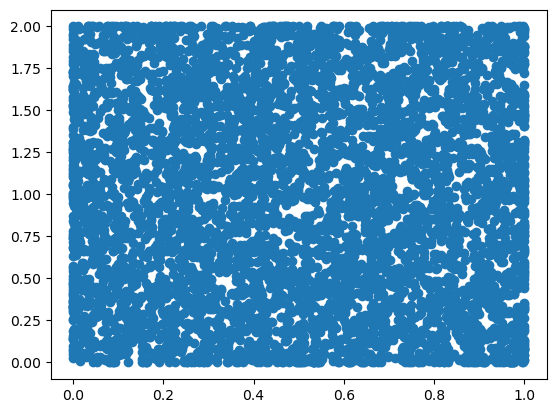

In [7]:
ut.plot_domain(domain)

In [8]:
loss_fn(model, domain)


KeyboardInterrupt



In [ ]:
train_ctx = train.TrainingContext(
    model=model,
    domain=domain,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=5_000,
)

loss_vals = train.train_switch_to_lbfgs(train_ctx)

Loss at epoch 1 is: 1.315292477607727
Loss at epoch 100 is: 0.7639517784118652
Loss at epoch 200 is: 0.45633336901664734


KeyboardInterrupt: 

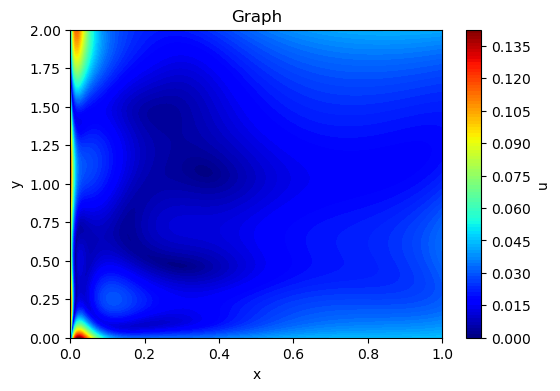

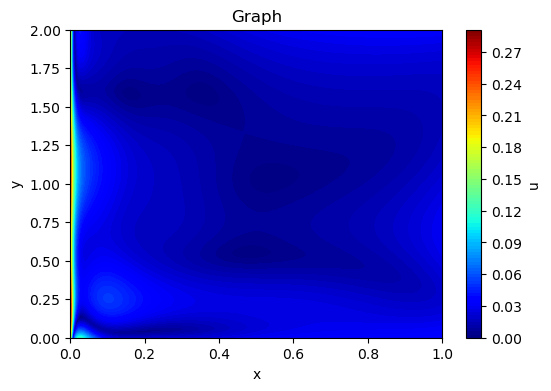

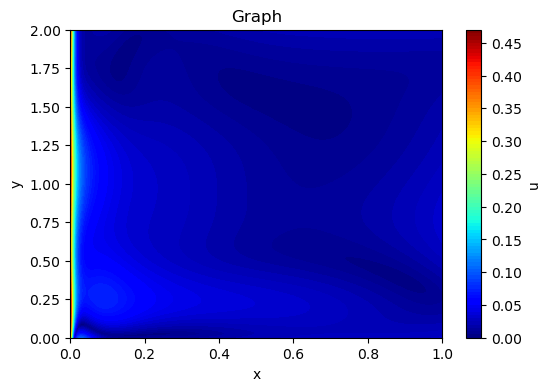

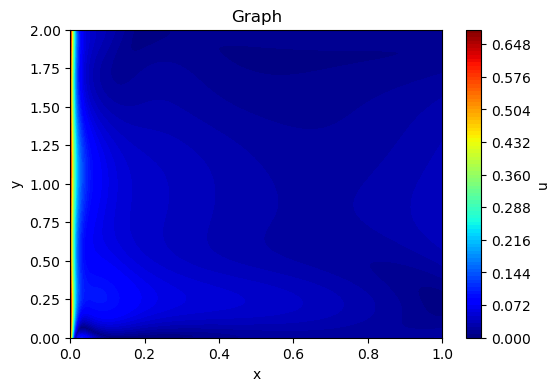

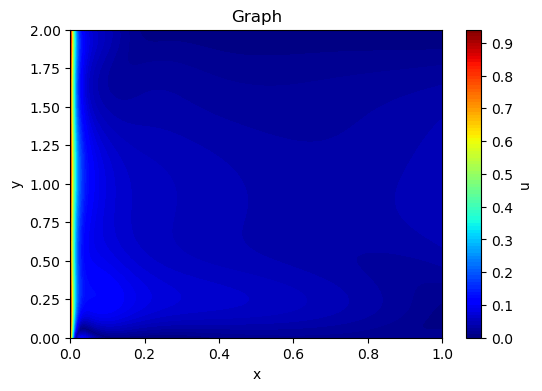

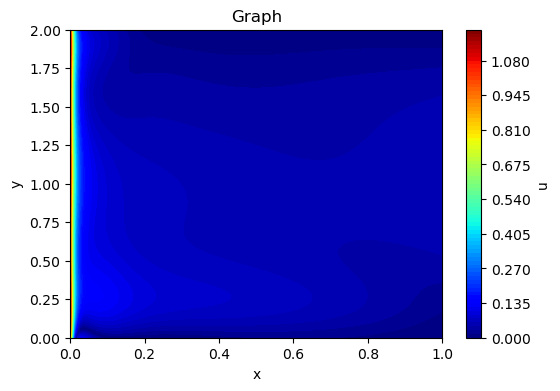

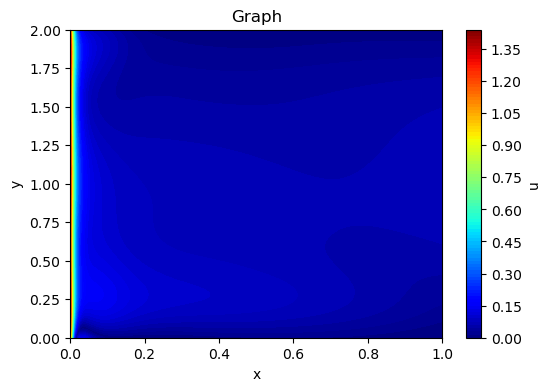

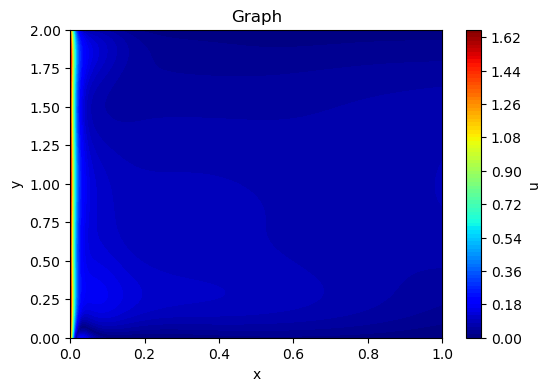

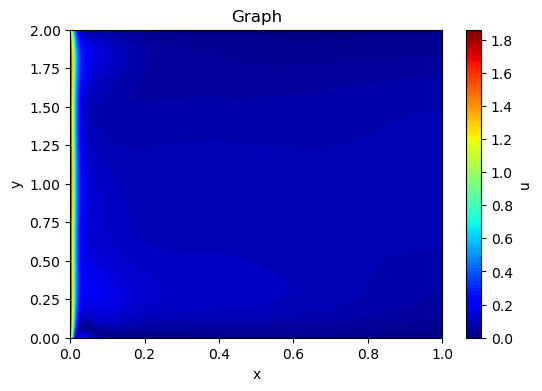

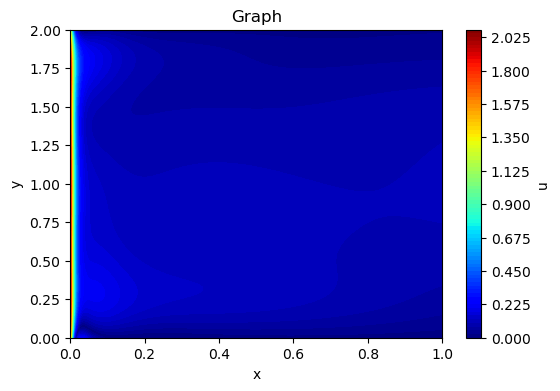

In [ ]:
plot_ctx = ut.PlotContext(
    l_bounds=[0, 0],
    u_bounds=[1, 2],
    device=device,
    patches=[],
    vmax=2,
    vmin=0
)

TIME = 0

def model_fixed_time(x: torch.Tensor):
        time = torch.full((x.shape[0], 1), TIME, device=device)
        x = torch.cat((x, time), dim=1)

        with torch.no_grad():
            u = model(x)[:, :-1]
        return torch.sqrt(u[:, 1]**2 + u[:, 0]**2)

for TIME in torch.linspace(0, 2, 10):
    ut.plot_function_on_2d_cube(model_fixed_time, plot_ctx)

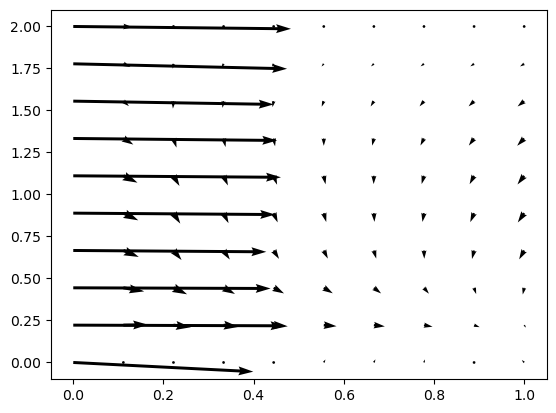

In [ ]:

def velocity_fix_time(x: torch.Tensor) -> torch.Tensor:
    time = torch.full((x.shape[0], 1), 1, device=device)
    x = torch.cat((x, time), dim=1)

    with torch.no_grad():
        u = model(x)[:, :-1]

    return u[:, 0:1], u[:, 1:2]

ut.plot_vector_field_2d(velocity_fix_time, plot_ctx)